# Feature Importance

The features are ordered with respect to their importance in the created dataset.

The feature importance are done based on two different techniques: SHAP values and Xgboost built-in feature importance(The XGBoost library provides a built-in function to plot features ordered by their importance)

In [1]:
%load_ext jupyter_black

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from utils import get_training_dataset

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Read csv file and import to df
df = pd.read_csv("data/updated_corr.csv")
df

,typhoon_name,typhoon_year,grid_point_id,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged,percent_houses_damaged_5years
0,DURIAN,2006,101,0.0,303.180555,0.122917,0.085417,31.000000,-0.213039,0.0,0.000000
1,DURIAN,2006,4475,0.0,638.027502,0.091667,0.027083,3.301020,-0.527000,0.0,0.000000
2,DURIAN,2006,4639,0.0,603.631997,0.535417,0.146354,12.103741,-0.283000,0.0,0.000000
3,DURIAN,2006,4640,0.0,614.675270,0.356250,0.101562,645.899660,-0.358889,0.0,0.000000
4,DURIAN,2006,4641,0.0,625.720905,0.202083,0.057812,1071.731293,-0.462800,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
141253,MOLAVE,2020,20677,0.0,644.575831,2.543750,0.778646,4449.357133,0.508167,0.0,0.000000
141254,MOLAVE,2020,20678,0.0,655.685233,2.558333,0.861458,1521.435795,-0.174100,0.0,0.000000
141255,MOLAVE,2020,20679,0.0,666.794635,2.975000,0.949479,930.647069,-0.244286,0.0,0.015207
141256,MOLAVE,2020,20680,0.0,677.904037,2.889583,1.083333,1800.666044,0.038000,0.0,0.020806


array([[<AxesSubplot:title={'center':'percent_houses_damaged'}>]],
      dtype=object)

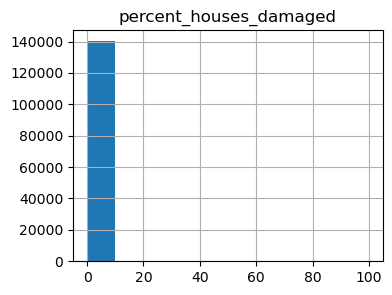

In [4]:
# Show histogram of damage
df.hist(column="percent_houses_damaged", figsize=(4, 3))

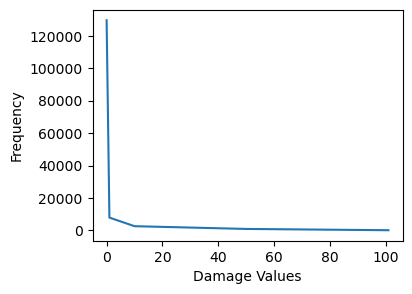

In [5]:
# Hist plot after data stratification
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [6]:
# Check the bins' intervalls (first bin means all zeros, second bin means 0 < values <= 1)
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    129600
(9e-05, 1.0]         7938
(1.0, 10.0]          2634
(10.0, 50.0]          939
(50.0, 101.0]         147
Name: percent_houses_damaged, dtype: int64

In [7]:
# Remove zeros from wind_speed
df = df[(df[["wind_speed"]] != 0).any(axis=1)]
df = df.drop(columns=["grid_point_id", "typhoon_year"])
df.head()

,typhoon_name,wind_speed,track_distance,rainfall_max_6h,rainfall_max_24h,total_houses,rwi,percent_houses_damaged,percent_houses_damaged_5years
138,DURIAN,12.460039,275.018491,0.670833,0.313021,0.479848,-0.213039,0.0,0.0
139,DURIAN,11.428974,297.027578,0.929167,0.343229,55.649739,0.206000,0.0,0.0
148,DURIAN,13.077471,262.598363,0.716667,0.424479,8.157414,-0.636000,0.0,0.0
149,DURIAN,12.511864,273.639330,0.568750,0.336979,88.292015,-0.227500,0.0,0.0
150,DURIAN,11.977511,284.680297,0.589583,0.290625,962.766739,-0.299667,0.0,0.0


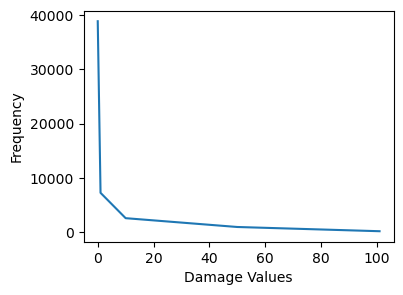

In [8]:
# Hist plot after removing rows where windspeed is 0
bins2 = [0, 0.00009, 1, 10, 50, 101]
samples_per_bin2, binsP2 = np.histogram(df["percent_houses_damaged"], bins=bins2)
plt.figure(figsize=(4, 3))
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [9]:
print(samples_per_bin2)
print(binsP2)

[38901  7232  2552   925   144]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [10]:
# Check the bins' intervalls
df["percent_houses_damaged"].value_counts(bins=binsP2)

(-0.001, 9e-05]    38901
(9e-05, 1.0]        7232
(1.0, 10.0]         2552
(10.0, 50.0]         925
(50.0, 101.0]        144
Name: percent_houses_damaged, dtype: int64

In [11]:
bin_index2 = np.digitize(df["percent_houses_damaged"], bins=binsP2)

In [12]:
y_input_strat = bin_index2

In [13]:
features = [
    "wind_speed",
    "track_distance",
    "total_houses",
    "rainfall_max_6h",
    "rainfall_max_24h",
    "rwi",
    "percent_houses_damaged_5years",
]

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["percent_houses_damaged"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['wind_speed', 'track_distance', 'total_houses', 'rainfall_max_6h',
       'rainfall_max_24h', 'rwi', 'percent_houses_damaged_5years'],
      dtype='object')

In [14]:
# Split dataset into training set and test set

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, df["percent_houses_damaged"], stratify=y_input_strat, test_size=0.2
)

In [15]:
# XGBoost Reduced Overfitting
xgb = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    colsample_bylevel=0.8,
    colsample_bynode=0.8,
    colsample_bytree=0.8,
    gamma=3,
    eta=0.01,
    importance_type="gain",
    learning_rate=0.1,
    max_delta_step=0,
    max_depth=4,
    min_child_weight=1,
    missing=1,
    n_estimators=100,
    early_stopping_rounds=10,
    n_jobs=1,
    nthread=None,
    objective="reg:squarederror",
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=None,
    subsample=0.8,
    verbosity=1,
    eval_metric=["rmse", "logloss"],
    random_state=0,
)

eval_set = [(X_test, y_test)]
xgb_model = xgb.fit(X_train, y_train, eval_set=eval_set, verbose=False)

[18:06:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [16]:
X_train4shapely = pd.DataFrame(data=X_train, columns=features)

In [17]:
explainer_xgb = shap.Explainer(xgb_model, X_train4shapely)
shap_values_xgb = explainer_xgb(X_train4shapely)

 98%|===================| 38995/39803 [00:32<00:00]        

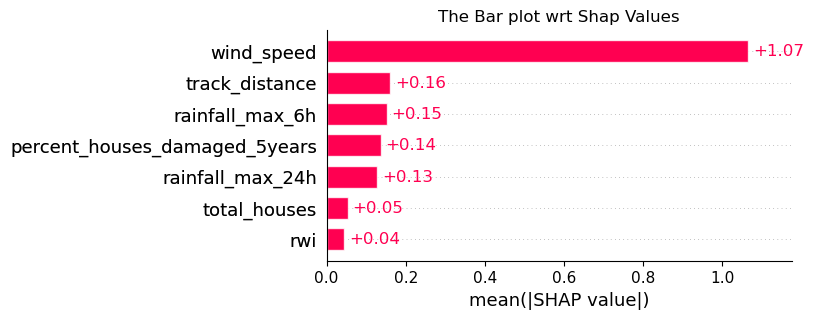

In [18]:
# Showing Barplot
plt.title("The Bar plot wrt Shap Values")
shap.plots.bar(shap_values_xgb, max_display=10, show=False)
plt.gcf().set_size_inches(6, 3)
plt.show()

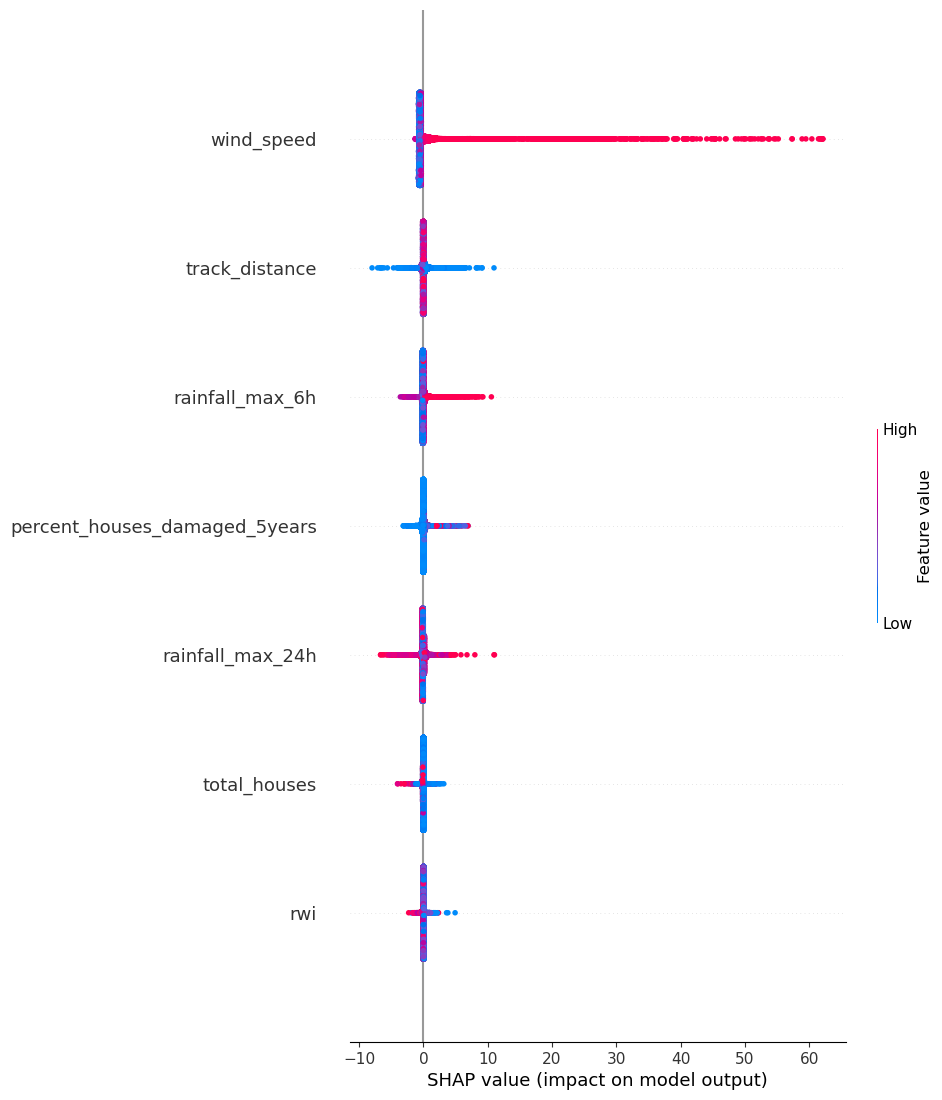

In [23]:
# Showing Beeswarm Plot
# plt.gcf().set_size_inches(4, 3)
shap.plots.beeswarm(
    shap_values_xgb,
    max_display=10,
    plot_size=1.7,
    # order=shap_values_xgb.abs.max(0)#, color="shap_red"
)

Text(0.5, 0, 'Feature Importance values')

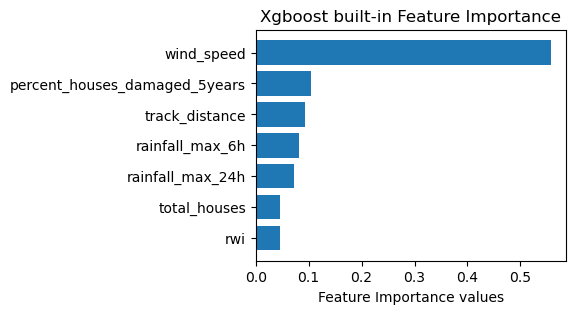

In [24]:
# Xgboost Built-in Feature Importance

plt.rcParams.update({"figure.figsize": (4.0, 3.0)})
plt.rcParams.update({"font.size": 10})

sorted_idx = xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.title("Xgboost built-in Feature Importance")
plt.xlabel("Feature Importance values")